In [1]:
## import python modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd
import xesmf as xe

import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
import datetime as dt
import importlib
import esmpy
import pyproj

%matplotlib inline

### Extract environment 

In [2]:
import analyze_feature
importlib.reload(analyze_feature)
from analyze_feature import FeatureEnv

In [3]:
THERMO_PATH='/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_'
PRECIP_PATH='/neelin2020/TRMM_3B42/TRMM.3hrly.3B42.'
WINDS_PATH='/neelin2020/ERA-5/winds/era-5_uv850_'
TRACKS_FILE = '/neelin2020/TempestExtremes/TC/ERA5_TC_tracks_20200824.txt'
SAVE_PATH='/neelin2020/Feature_env/TC_env_'
YEAR=2014

## set environment info. ###
env_var_info={}
date_str_info={}
var_transform={}
regridding={}

key=('thetae_bl','thetae_lt','thetae_sat_lt')
env_var_info[key]=THERMO_PATH
date_str_info[key]='%Y_%m_%d'
var_transform[key]=lambda x:x
regridding[key]=False

key=('precip_trmm',)
env_var_info[key]=PRECIP_PATH
date_str_info[key]='%Y%m*'
var_transform[key]=lambda x:x.rename({'latitude':'lat','longitude':'lon'})
regridding[key]=False

key=('u','v')
env_var_info[key]=WINDS_PATH
date_str_info[key]='%Y_%m_%d'
regridding[key]=True

def manipulate_era5_uv(x):
    x=x.rename({'latitude':'lat','longitude':'lon','isobaricInhPa':'lev'}).drop(('number','step','valid_time','lev'))
    x=x.isel(lat=slice(None, None, -1))
    x=x.assign_coords(lon=(x.lon+360)%360).sortby('lon')
    return x

var_transform[key]= manipulate_era5_uv  

dim_vars={}
dim_vars['lat']='lat'
dim_vars['lon']='lon'
dim_vars['time']='time'

OFFSET=7.5 ## deg. of latitude

In [4]:
obj=FeatureEnv(YEAR,TRACKS_FILE,env_var_info,date_str_info,var_transform,dim_vars,regridding,
               OFFSET,SAVE_PATH)

In [5]:
%%timeit -n 1 -r 1
obj.extract_te_tracks() ## extract features for a given year
obj.get_lat_lon_info()  ## extract grid info.

There are 87 features in 2014
1.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Check TC tracks 

In [6]:
psl_array=[]
max_wind_array=[]
for k in list(obj.feature_tracks.keys()):
    psl_array.append(obj.feature_tracks[k]['psl'].min())
    max_wind_array.append(obj.feature_tracks[k]['max_wind'].max())

df = pd.DataFrame({'min psl': psl_array, 'max wind': max_wind_array})
df=df.sort_values('min psl')
display(df)

,min psl,max wind
65,948.3969,33.12313
67,949.2738,31.87799
47,950.6525,36.10097
40,955.0194,33.25447
70,959.2344,34.91219
...,...,...
45,1003.1310,18.30308
0,1003.1810,16.36333
18,1003.9160,17.02907
81,1004.9910,16.91999


### Plot TC tracks 

Text(0.05, 0.2, 'min. psl=\n949.27 hPA')

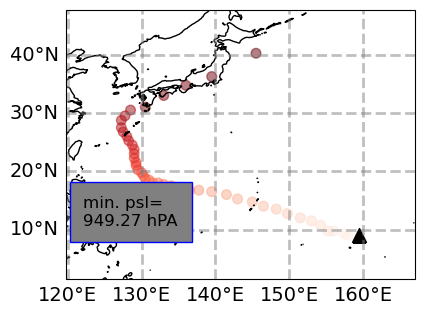

In [7]:
## pick any TC to see track
TC_NUMBER=67
fig,axx = plt.subplots(1,1,figsize=(4.5, 3.5),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

ax=axx
ax.coastlines()
obj.plot_tracks(TC_NUMBER,ax)
ax.text(0.05,0.2,'min. psl=\n{:.2f} hPA'.format(obj.feature_tracks[TC_NUMBER]['psl'].min()),
        transform=ax.transAxes,fontsize=12, bbox=dict(facecolor='grey', edgecolor='blue', pad=10.0))

In [ ]:
%%timeit -n 1 -r 1
for fn in [65,67]:
    obj.extract_env_save(fn)

### Processing 

In [8]:
import analyze_feature
importlib.reload(analyze_feature)
from analyze_feature import *

In [9]:
## read feature environment
FEAT_NUMBER=65
SAVE_PATH='/neelin2020/Feature_env/TC_env_'
plot_obj=ProcessFeatureEnv(SAVE_PATH,FEAT_NUMBER,YEAR)

In [10]:
### initalize functions to compute buoy components
instab_compute=lambda x: (x.thetae_bl - x.thetae_sat_lt) * 340. / x.thetae_sat_lt
subsat_compute=lambda x: (x.thetae_sat_lt - x.thetae_lt) * 340. / x.thetae_sat_lt
buoy_compute=lambda x: (0.5 * x.instab - 0.5 * x.subsat) * 9.8 / 340.

var_compute={'instab':instab_compute,
             'subsat':subsat_compute,
             'buoy':buoy_compute}

plot_obj.compute_secondary_vars(var_compute)

In [11]:
## compute composites 

## grid spacing 25 km is roughly equiv. to native ERA5 grid
xdim=np.arange(-725,750,25)*1e3
ydim=np.arange(-700,725,25)*1e3


var_list=['instab','subsat','buoy','precip_trmm','u','v']
ret=plot_obj.compute_composites(var_list,xdim,ydim)


In [12]:
## precip. statistics binning
instab_bins=np.arange(-25,12.5,2.5)
subsat_bins=np.arange(-5,32.5,2.5)
buoy_bins=np.arange(-0.5,0.12,0.02)

plot_obj.compute_prc_buoy_stats(buoy_bins,instab_bins,subsat_bins)


### Plotting 

In [13]:
PLT_DIR='/home/fiaz/feature_env/plots/'

### Avg. overlapping grids

/tmp/ipykernel_256600/3083961838.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


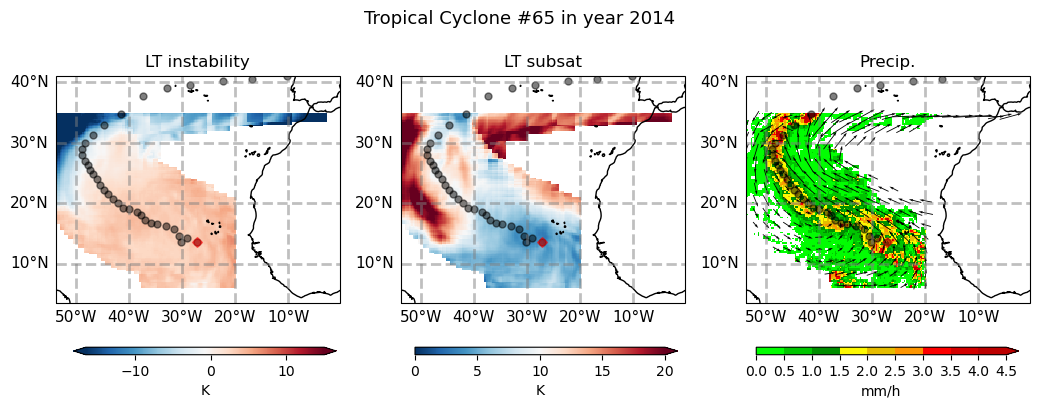

In [14]:
SAVE=True
lon0=plot_obj.ds.lon0
lat0=plot_obj.ds.lat0

fig,axx = plt.subplots(1,3,figsize=(10.5, 3.),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

ax=axx[0]
var=plot_obj.ds.instab.mean(dim='time')
cmap=plt.get_cmap('RdBu_r')
cbar_kwargs={'cax':fig.add_axes([0.075,-0.05,0.25,0.025]),
             'orientation':'horizontal','label':'K'}
time_mean_plot(ax,var,[-15,15],cmap,cbar_kwargs,'LT instability',lat0,lon0)




ax=axx[1]
var=plot_obj.ds.subsat.mean(dim='time')
cmap=plt.get_cmap('RdBu_r')
cbar_kwargs={'cax':fig.add_axes([0.4,-0.05,0.25,0.025]),
             'orientation':'horizontal','label':'K'}
time_mean_plot(ax,var,[20,0],cmap,cbar_kwargs,'LT subsat',lat0,lon0)

ax=axx[2]
var=plot_obj.ds.precip_trmm.mean(dim='time')
var=var.where(var>0)

cmap=precip_colormap
norm=prc_norm

cbar_kwargs={'cax':fig.add_axes([0.725,-0.05,0.25,0.025]),
             'orientation':'horizontal','label':'mm/h'}
time_mean_plot(ax,var,[None,None],cmap, cbar_kwargs, 'Precip.',lat0,lon0,norm=norm)

comp=plot_obj.ds.mean('time').isel(lat=slice(1,-1,8),lon=slice(1,-1,8))
quiver = comp.plot.quiver(ax=ax, x='lon', y='lat', u='u', v='v',
                              scale=2.5e2, color='black',add_guide = False)      
ax.set_title('Precip.',fontsize=12)

plt.tight_layout()
plt.suptitle('Tropical Cyclone #{:2d} in year {:d}'.format(FEAT_NUMBER,YEAR),fontsize=13,
             y=1.1,x=.5)


if SAVE:
    fig_name=PLT_DIR+'Overlapping_composite_env_TC_{:2d}_{}.pdf'.format(FEAT_NUMBER,YEAR)
    plt.savefig(fig_name,format='pdf',bbox_inches='tight',dpi=125)



### Plot composites ###

/tmp/ipykernel_256600/2518635927.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


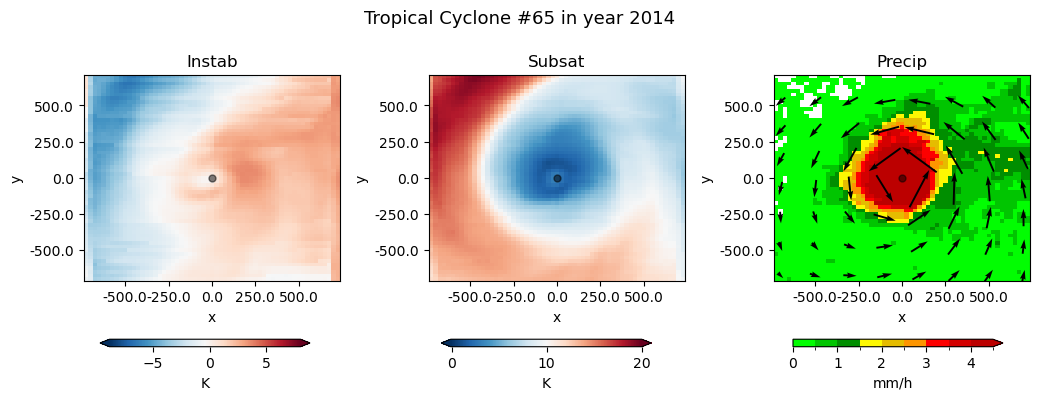

In [15]:
SAVE=True
fig,axx = plt.subplots(1,3,figsize=(10.5, 3.),constrained_layout=False)

ax=axx[0]
cmap=plt.get_cmap('RdBu_r')
cbar_kwargs={'cax':fig.add_axes([0.10,-0.025,0.2,0.025]),
             'orientation':'horizontal','label':'K'}

var=plot_obj.ds_composite.instab.mean('time')
title='Instab'
composite_plot(ax, var, [-8,8], cmap, cbar_kwargs, 
               title, norm=None)

ax=axx[1]
cmap=plt.get_cmap('RdBu_r')
cbar_kwargs={'cax':fig.add_axes([0.425,-0.025,0.2,0.025]),
             'orientation':'horizontal','label':'K'}

var=plot_obj.ds_composite.subsat.mean('time')
title='Subsat'
composite_plot(ax, var, [0,20], cmap, cbar_kwargs, 
               title, norm=None)

ax=axx[2]
cmap=plt.get_cmap('RdBu_r')
cbar_kwargs={'cax':fig.add_axes([0.76,-0.025,0.2,0.025]),
             'orientation':'horizontal','label':'mm/h'}

cmap=precip_colormap
norm=prc_norm

var=plot_obj.ds_composite.precip_trmm.mean('time')
var=var.where(var>0)


title='Precip.'
cb=composite_plot(ax, var, [None,None], cmap, cbar_kwargs, 
               title, norm=prc_norm)
cb.colorbar.ax.xaxis.set_major_locator(mticker.MultipleLocator(1.))
winds=plot_obj.ds_composite.mean('time').isel(x=slice(1,-1,8),y=slice(1,-1,8))
quiver = winds.plot.quiver(ax=ax, x='x', y='y', u='u', v='v',
                              scale=2e2, color='black',add_guide = False)      

ax.set_title('Precip',fontsize=12)

plt.tight_layout()
plt.suptitle('Tropical Cyclone #{:2d} in year {:d}'.format(FEAT_NUMBER,YEAR),fontsize=13,
             y=1.1,x=.5)



if SAVE:
    fig_name=PLT_DIR+'Composite_TC_env_{:2d}_{}.pdf'.format(FEAT_NUMBER,YEAR)
    plt.savefig(fig_name,format='pdf',bbox_inches='tight',dpi=125)



### Plot snapshots

In [16]:
## get 10 equally-spaced time steps for plotting 
time_idx=np.int_(np.linspace(0,plot_obj.ds.time.size-1,10))

/tmp/ipykernel_256600/2050192742.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


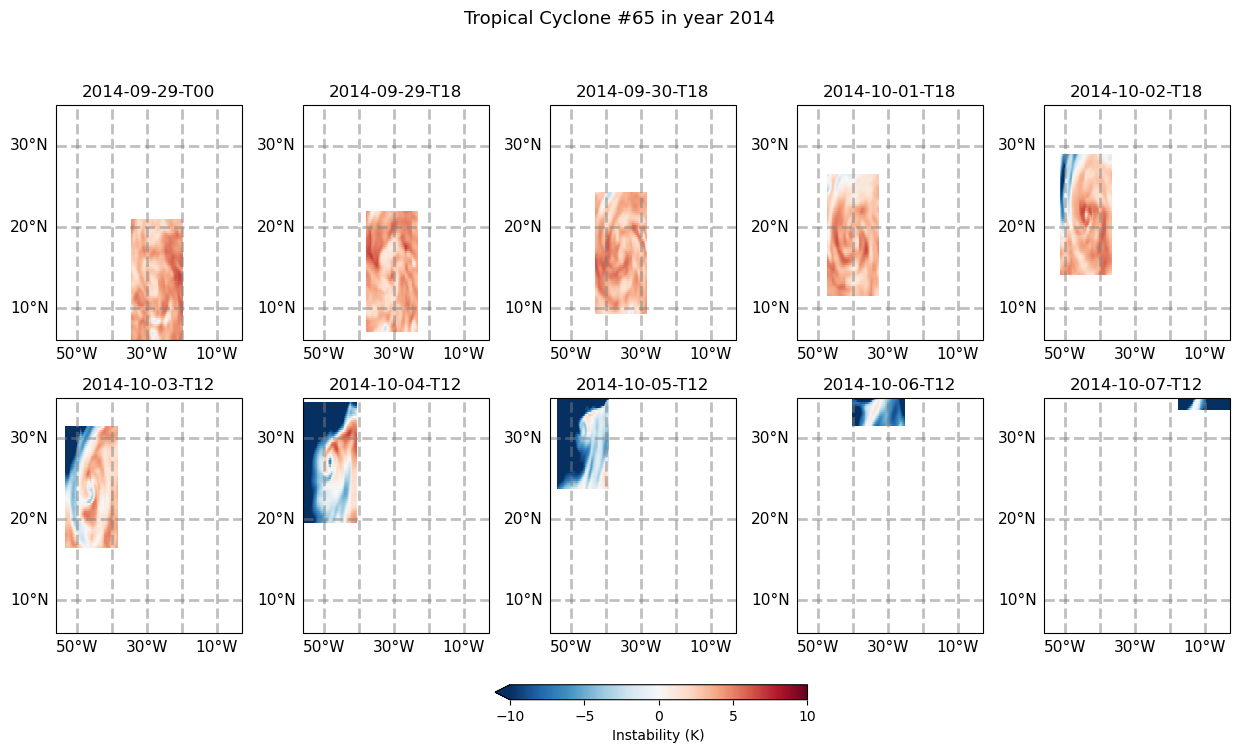

In [17]:
SAVE=True
lon0=plot_obj.ds.lon0
lat0=plot_obj.ds.lat0
convert_to_date_str=lambda x: dt.datetime.strftime(pd.Timestamp(x.time.values).to_pydatetime(),"%Y-%m-%d-T%H")

fig,axx = plt.subplots(2,5,figsize=(12.5, 6.),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

extent=[lon0.min()-5,lon0.max()+10,
        lat0.min()-10,lat0.max()-5]


for i in range(time_idx.size):
    n=i//5
    m=np.mod(i,5)
    ax=axx[n,m]
    cmap=plt.get_cmap('RdBu_r')

    
    var=plot_obj.ds.instab.isel(time=time_idx[i])
    time_str=convert_to_date_str(var)

    if i<9:
        cbar_kwargs=None
        snapshot_plot(ax, var, [-10,10], 
                      cmap, cbar_kwargs, time_str, cbar_on=False, norm=None)
    else:
        
        cbar_kwargs={'cax':fig.add_axes([0.4,-0.05,0.25,0.025]),
             'orientation':'horizontal','label':'Instability (K)'}
        snapshot_plot(ax, var, [-10,10], 
                      cmap, cbar_kwargs, time_str, cbar_on=True, norm=None)

plt.tight_layout()
plt.suptitle('Tropical Cyclone #{:2d} in year {:d}'.format(FEAT_NUMBER,YEAR),fontsize=13,
             y=1.1,x=.5)

if SAVE:
    fig_name=PLT_DIR+'Snapshot_TC_env_{:2d}_{}.pdf'.format(FEAT_NUMBER,YEAR)
    plt.savefig(fig_name,format='pdf',bbox_inches='tight',dpi=125)



### Plot precipitation statistics

/tmp/ipykernel_256600/2820358734.py:12: RuntimeWarning: divide by zero encountered in log
  CT=ax.pcolormesh(subsat_bins,instab_bins,np.log(plot_obj.precip_hist_2d))
/tmp/ipykernel_256600/2820358734.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


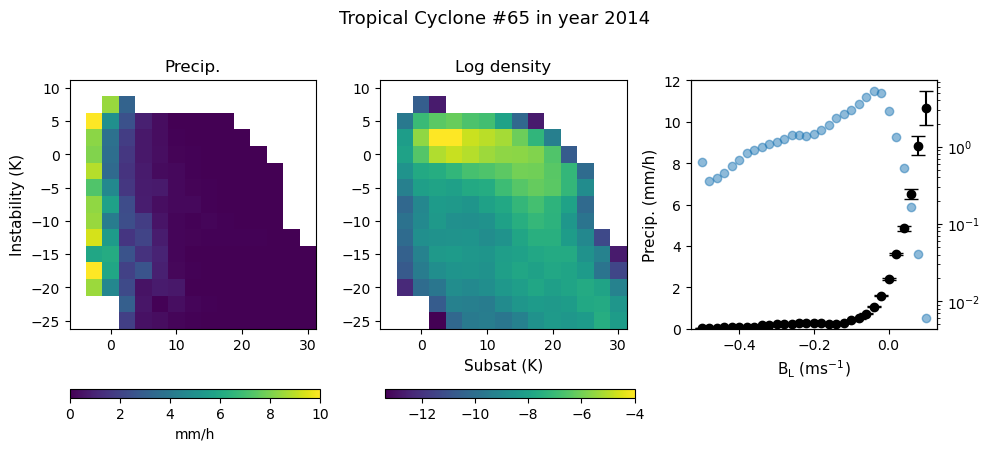

In [19]:
SAVE=True
fig,axx=plt.subplots(1,3,figsize=(10,3.5))

ax=axx[0]
CT=ax.pcolormesh(subsat_bins,instab_bins,plot_obj.precip_binned_2d,vmin=0,vmax=10)
ax.set_ylabel('Instability (K)', fontsize=11)
cax=fig.add_axes([0.075,-0.01,0.25,0.025])
cb=plt.colorbar(CT,label='mm/h',orientation='horizontal',cax=cax)
ax.set_title('Precip.', fontsize=12)

ax=axx[1]
CT=ax.pcolormesh(subsat_bins,instab_bins,np.log(plot_obj.precip_hist_2d))
# ax.set_ylabel('Instability (K)', fontsize=11)
ax.set_xlabel('Subsat (K)', fontsize=11)
cax=fig.add_axes([0.39,-0.01,0.25,0.025])
cb=plt.colorbar(CT,label='',orientation='horizontal',cax=cax)
ax.set_title('Log density', fontsize=12)


ax=axx[2]
ax.errorbar(buoy_bins,plot_obj.precip_binned_1d, color='black',
             yerr=plot_obj.precip_stderr_1d,fmt='o',capsize=5)
ax.set_ylim(bottom=0)
ax.set_xlabel('$\mathrm{B_L}$ $\mathrm{(ms^{-1})}$',fontsize=11)
ax.set_ylabel('Precip. (mm/h)',fontsize=11)

ax2=ax.twinx()
ax2.scatter(buoy_bins,plot_obj.precip_hist_1d,alpha=0.5)
ax2.set_yscale('log')

plt.tight_layout()
plt.suptitle('Tropical Cyclone #{:2d} in year {:d}'.format(FEAT_NUMBER,YEAR),fontsize=13,
             y=1.1,x=.5)

if SAVE:
    fig_name=PLT_DIR+'Precip_stats_TC_env_{:2d}_{}.pdf'.format(FEAT_NUMBER,YEAR)
    plt.savefig(fig_name,format='pdf',bbox_inches='tight',dpi=125)